In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [40]:
file_name = '28965814 (2).csv'

df = pd.read_csv(file_name)
df.columns

Index(['YYYY/MM/DD', 'HH:MM:SS', 'Hole Depth (feet)', 'Bit Depth (feet)',
       'Rate Of Penetration (ft_per_hr)', 'Weight on Bit (klbs)',
       'Rotary RPM (RPM)', 'Standpipe Pressure (psi)', 'Hook Load (klbs)',
       'Differential Pressure (psi)', 'Flow (flow_percent)',
       'Total Pump Output (gal_per_min)', 'On Bottom Hours (hrs)',
       'Pump Total Strokes Rate (SPM)', 'Bit RPM (RPM)',
       'Inclination (degrees)', 'Azimuth (degrees)',
       'AutoDriller On Bottom ROP Setpoint (ft_per_hr)',
       'AutoDriller ROP Response Tuning (unitless)',
       'AutoDriller Torque (ft_lb)', 'AutoDriller WOB (klbs)',
       'Bit RPM (RPM).1', 'Bit Torque (kft_lb)', 'Depth of Cut (in)',
       'Downhole MSE (ksi)', 'EDR Instantaneous ROP (ft_per_hr)',
       'Mechanical Specific Energy (ksi)', 'Top Drive Torque (kft_lb)',
       'Top Drive Rotary (RPM)', 'Standpipe Pressure (psi).1',
       'Total MSE (ksi)', 'Autodriller Sensitivity (unitless)',
       'AutoDriller Torque Min (ft_lb)'

In [51]:
# print(df['AutoDriller WOB (klbs).1'])


1970-01-01 00:00:00   -999.25
1970-01-01 00:00:01   -999.25
1970-01-01 00:00:02   -999.25
1970-01-01 00:00:03   -999.25
1970-01-01 00:00:04   -999.25
                        ...  
1970-03-17 06:13:58    214.10
1970-03-17 06:13:59    214.11
1970-03-17 06:14:00    214.03
1970-03-17 06:14:01    214.01
1970-03-17 06:14:02    213.95
Name: AutoDriller WOB (klbs).1, Length: 6502443, dtype: float64


In [41]:
# Convert 'Time (sec)' index to datetime format in seconds
df.index = pd.to_datetime(df.index, unit='s')

# Find rows where Rate of Penetration (ft_per_hr) and Bit RPM (RPM) are greater than zero
df['is_drilling'] = (df['Rate Of Penetration (ft_per_hr)'] > 0) & (df['Bit RPM (RPM)'] > 0)

# Detect moments when drilling starts (when the previous row is_drilling is false, and the current row is true, meaning drilling has just started)
df['bit_run_start'] = df['is_drilling'] & (~df['is_drilling'].shift(1, fill_value=False))

# Mark the data for exclusion for 1 minute after each drilling start
df['exclude'] = False  # Add a column to mark rows to be filtered out

# Gather all bit run start times
start_times = df.loc[df['bit_run_start']].index

# Mark the data for exclusion for 1 minute after each start time
for start_time in start_times:
    df.loc[(df.index >= start_time) & (df.index < start_time + pd.Timedelta(seconds=90)), 'exclude'] = True

# Filter out the 1-minute periods and drop unnecessary columns
filtered_data = df[df['exclude'] == False].drop(columns=['is_drilling', 'bit_run_start', 'exclude']).reset_index()

# Review the result
print(filtered_data)

                      index  YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  \
0       1970-01-01 00:00:00  2023/11/04  17:15:00               66.4   
1       1970-01-01 00:00:01  2023/11/04  17:15:01               66.4   
2       1970-01-01 00:00:02  2023/11/04  17:15:02               66.4   
3       1970-01-01 00:00:03  2023/11/04  17:15:03               66.4   
4       1970-01-01 00:00:04  2023/11/04  17:15:04               66.4   
...                     ...         ...       ...                ...   
6457277 1970-03-17 06:13:58  2024/01/19  14:59:56             9220.0   
6457278 1970-03-17 06:13:59  2024/01/19  14:59:57             9220.0   
6457279 1970-03-17 06:14:00  2024/01/19  14:59:58             9220.0   
6457280 1970-03-17 06:14:01  2024/01/19  14:59:59             9220.0   
6457281 1970-03-17 06:14:02  2024/01/19  15:00:00             9220.0   

         Bit Depth (feet)  Rate Of Penetration (ft_per_hr)  \
0                     2.0                              0.0   
1          

In [42]:
filtered_data['Time (sec)'] = filtered_data.index

# Calculate the depth difference
depth_difference = abs(filtered_data['Bit Depth (feet)'] - filtered_data['Hole Depth (feet)'])

# Define start and end conditions to exclude data where WOB, ROP, and Rotary RPM start from or go to zero
# Start and end conditions are defined by checking when the absolute differences in WOB, ROP, and Rotary RPM change
start_condition = (filtered_data['Weight on Bit (klbs)'].diff().abs() > 0) & (filtered_data['Rate Of Penetration (ft_per_hr)'].diff().abs() > 0) & (filtered_data['Rotary RPM (RPM)'].diff().abs() > 0)
end_condition = start_condition[::-1]

# Exclude the first and last 10 seconds of data
first_10_sec = filtered_data[start_condition].head(400).index
last_10_sec = filtered_data[end_condition].head(400).index

# Drop the identified rows and ignore errors if any
filtered_data = filtered_data.drop(first_10_sec, errors='ignore').drop(last_10_sec, errors='ignore')

# Ensure ROP, WOB, and Rotary RPM are greater than zero, and the difference between Bit Depth and Hole Depth is zero
filtered_data = filtered_data[(depth_difference == 0) & (filtered_data['Rate Of Penetration (ft_per_hr)'] > 0) & (filtered_data['Rotary RPM (RPM)'] > 0)]

# Reset the index of the DataFrame and rename the index as "Time (sec)"
filtered_data = filtered_data.reset_index(drop=True)
filtered_data = filtered_data.rename_axis('Time (sec)')

# Print the filtered DataFrame
print(filtered_data)

/var/folders/k_/3zq1wgz91k71jhlffkwkhc3c0000gn/T/ipykernel_17271/198919540.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_10_sec = filtered_data[end_condition].head(400).index
/var/folders/k_/3zq1wgz91k71jhlffkwkhc3c0000gn/T/ipykernel_17271/198919540.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[(depth_difference == 0) & (filtered_data['Rate Of Penetration (ft_per_hr)'] > 0) & (filtered_data['Rotary RPM (RPM)'] > 0)]


                         index  YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  \
Time (sec)                                                                
0          1970-01-01 22:27:12  2023/11/05  14:42:12               88.1   
1          1970-01-01 22:27:13  2023/11/05  14:42:13               88.1   
2          1970-01-01 22:27:14  2023/11/05  14:42:14               88.1   
3          1970-01-01 22:27:15  2023/11/05  14:42:15               88.1   
4          1970-01-01 22:27:16  2023/11/05  14:42:16               88.1   
...                        ...         ...       ...                ...   
823978     1970-03-10 15:10:06  2024/01/12  23:46:02             9220.0   
823979     1970-03-10 15:10:07  2024/01/12  23:46:03             9220.0   
823980     1970-03-10 15:10:08  2024/01/12  23:46:04             9220.0   
823981     1970-03-10 15:10:09  2024/01/12  23:46:05             9220.0   
823982     1970-03-10 15:10:10  2024/01/12  23:46:06             9220.0   

            Bit Depth (f

In [43]:
min_depth = 2000
max_depth = 4000
filtered_data = filtered_data[(filtered_data['Hole Depth (feet)'] >= min_depth) & (filtered_data['Hole Depth (feet)'] <= max_depth)]
filtered_data
# #filtered_data = filtered_data[(filtered_data.index >= 400000) & (filtered_data.index <= 420000)]


,index,YYYY/MM/DD,HH:MM:SS,Hole Depth (feet),Bit Depth (feet),Rate Of Penetration (ft_per_hr),Weight on Bit (klbs),Rotary RPM (RPM),Standpipe Pressure (psi),Hook Load (klbs),...,Standpipe Pressure (psi).2,Total MSE (ksi).1,Top Drive Torque (kft_lb).1,Weight on Bit (klbs).1,Rate Of Penetration (ft_per_hr).1,EDR Instantaneous ROP (ft_per_hr).1,Block Height (feet),Rotary RPM (RPM).1,Surface Stick Slip Index (percent),Time (sec)
Time (sec),,,,,,,,,,,,,,,,,,,,,
77485,1970-01-07 17:55:16,2023/11/11,10:32:16,2000.0,2000.0,267.54,50.3,64.73,2461.53,66.3,...,2461.53,22.5,18.812,50.3,267.54,267.541,1.6,64.73,13.0,572998
77486,1970-01-07 17:55:17,2023/11/11,10:32:17,2000.1,2000.1,267.35,52.7,64.38,2477.70,66.0,...,2477.70,23.1,18.852,52.7,267.35,267.353,1.5,64.38,13.0,572999
77487,1970-01-07 17:55:18,2023/11/11,10:32:18,2000.2,2000.2,265.97,53.6,65.08,2484.99,64.0,...,2484.99,23.1,18.800,53.6,265.97,265.972,1.4,65.08,13.0,573000
77488,1970-01-07 17:55:19,2023/11/11,10:32:19,2000.2,2000.2,263.58,53.6,58.44,2518.06,69.8,...,2518.06,24.0,19.368,53.6,263.58,263.583,1.3,58.44,13.0,573001
77489,1970-01-07 17:55:20,2023/11/11,10:32:20,2000.3,2000.3,261.58,45.5,64.07,2522.67,72.0,...,2522.67,24.5,19.109,45.5,261.58,261.583,1.3,64.07,12.9,573002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200630,1970-02-05 08:33:23,2023/12/10,02:30:41,4000.0,4000.0,25.62,31.3,69.01,206.10,142.8,...,206.10,130.1,7.236,31.3,25.62,25.594,16.1,69.01,2.0,3030768
200631,1970-02-05 08:33:24,2023/12/10,02:30:42,4000.0,4000.0,25.58,30.9,69.12,206.12,143.2,...,206.12,129.4,7.178,30.9,25.58,26.388,16.1,69.12,2.0,3030769
200632,1970-02-05 08:33:25,2023/12/10,02:30:43,4000.0,4000.0,25.54,30.8,68.70,206.10,142.9,...,206.10,128.9,7.186,30.8,25.54,27.120,16.1,68.70,2.0,3030770


In [44]:
# # Combine the "YYYY/MM/DD" and "HH:MM:SS" columns to form a datetime column 
# # insert new columns right after the "YYYY/MM/DD" and "HH:MM:SS" columns
# loc_datetime = df.columns.get_loc('HH:MM:SS') + 1

# df.insert(loc_datetime, 'Datetime', 
#                                     pd.to_datetime(df['YYYY/MM/DD'] + ' ' + df['HH:MM:SS'])
#                                     )

# # Locate the location of the new "Datetime" column
# loc_time_sec = df.columns.get_loc('Datetime') + 1

# # Subtract the first datetime from all the other datetimes to get time difference in seconds
# time_difference = df['Datetime'] - df['Datetime'].iloc[0]
# df.insert(loc_time_sec, 'Time (sec)', time_difference.dt.total_seconds())

In [45]:
# def detect_rop_anomalies(filtered_data, rop_col="Rate Of Penetration (ft_per_hr)", threshold=3.5, window_size=45, ignore_duration=15):
#     """
#     Detects anomalies by calculating the derivative of ROP and checking if it exceeds a certain threshold.
#     After a rise/drop is detected, derivative calculation is ignored for a specified duration.

#     Args:
#     filtered_data (pd.DataFrame): DataFrame containing time series data with Time (sec) as the index.
#     rop_col (str): Column name where Rate Of Penetration (ft_per_hr) values are stored.
#     threshold (float): Derivative threshold considered as an abnormal increase.
#     window_size (int): Window size in seconds for calculating rolling average of derivatives.
#     ignore_duration (int): Duration in seconds to ignore derivative calculations after a sudden rise/drop.

#     Returns:
#     pd.DataFrame: DataFrame with added columns for anomaly detection and derivative values.
#     """
    
#     # Calculate the derivative (gradient) of the Rate Of Penetration with respect to the Time (sec) index
#     filtered_data['ROP_derivative'] = np.gradient(filtered_data[rop_col], filtered_data.index)
    
#     # Create a mask to ignore derivative calculations for 'ignore_duration' seconds after a sudden rise/drop
#     ignore_mask = np.zeros(len(filtered_data), dtype=bool)
#     for i in range(1, len(filtered_data)):
#         if abs(filtered_data['ROP_derivative'].iloc[i] - filtered_data['ROP_derivative'].iloc[i-1]) > threshold:
#             ignore_mask[i:i+ignore_duration] = True
    
#     # Reset the derivative for the ignore period to avoid false anomaly detection
#     filtered_data.loc[ignore_mask, 'ROP_derivative'] = np.nan  # Set derivative as NaN to ignore
#     filtered_data['ROP_derivative'] = filtered_data['ROP_derivative'].fillna(method='bfill')  # Optionally fill with next valid value
    
#     # Mark anomalies based on the derivative exceeding the threshold
#     filtered_data['anomaly'] = filtered_data['ROP_derivative'].apply(lambda x: 1 if x > threshold else 0)
    
#     # Calculate the rolling mean of the derivative over the defined window size and mark sustained anomalies
#     filtered_data['rolling_mean_derivative'] = filtered_data['ROP_derivative'].rolling(window=window_size).mean()
#     filtered_data['sustained_anomaly'] = filtered_data['rolling_mean_derivative'].apply(lambda x: 1 if x > threshold else 0)
    
#     return filtered_data


# def detect_anomaly_start_points(result_df):
#     """
#     Detects the starting points of sustained anomalies.

#     Args:
#     result_df (pd.DataFrame): DataFrame containing the 'sustained_anomaly' column.

#     Returns:
#     pd.DataFrame: Table containing the ROP, Hole Depth, and Time (index) values for the sustained anomaly starting points.
#     """
#     # Find the starting points of sustained anomalies (transition from 0 to 1)
#     anomaly_start_points = result_df[(result_df['sustained_anomaly'] == 1) & (result_df['sustained_anomaly'].shift(1) == 0)]
    
#     # Use the result_df.index for the Time values
#     anomaly_start_points['Time (sec)'] = anomaly_start_points.index
    
#     return anomaly_start_points[['Rate Of Penetration (ft_per_hr)', 'Hole Depth (feet)', 'Time (sec)']]


# def plot_rop_anomalies_with_ignore_periods(result_df, rop_col="Rate Of Penetration (ft_per_hr)", depth_col="Hole Depth (feet)"):
#     """
#     Plots the Rate Of Penetration (ROP) and sustained anomaly start points with ignored periods for derivative calculations.

#     Args:
#     result_df (pd.DataFrame): DataFrame containing ROP, sustained anomaly, and derivative data.
#     rop_col (str): Name of the ROP column.
#     depth_col (str): Name of the Hole Depth (feet) column.
#     """
#     # Detect sustained anomaly start points
#     anomaly_start_points = detect_anomaly_start_points(result_df)

#     # Create the plot
#     fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

#     # Plot ROP and sustained anomalies
#     ax[0].plot(result_df.index, result_df[rop_col], label='ROP', color='blue')
#     ax[0].set_ylabel('ROP (ft/hr)')
#     ax[0].set_title('Rate of Penetration (ROP) with Ignored Derivative Periods and Anomalies')
    
#     # Mark periods where derivative calculations were ignored (NaN in 'ROP_derivative')
#     ignored_periods = result_df[result_df['ROP_derivative'].isna()]
#     ax[0].scatter(ignored_periods.index, ignored_periods[rop_col], label='Ignored Period', color='orange', s=10, marker='x')

#     # Plot sustained anomalies
#     ax[1].plot(result_df.index, result_df['sustained_anomaly'], label='Sustained Anomaly', color='purple', linestyle='--')
#     ax[1].set_ylabel('Sustained Anomaly')
#     ax[1].set_title('Sustained Anomalies')

#     # Mark sustained anomaly start points with red dots
#     for idx, row in anomaly_start_points.iterrows():
#         ax[0].plot(idx, row[rop_col], 'ro')  # Add red dots for ROP

#     ax[1].set_xlabel('Hole Depth (feet)')
    
#     plt.tight_layout()
#     plt.legend()
#     plt.show()

#     # Print the table of anomaly start points
#     print("Anomaly Start Points Table:")
#     display(anomaly_start_points)


# result_df = detect_rop_anomalies(filtered_data, rop_col='Rate Of Penetration (ft_per_hr)')
# plot_rop_anomalies_with_ignore_periods(result_df, rop_col='Rate Of Penetration (ft_per_hr)', depth_col='Hole Depth (feet)')



In [46]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# def detect_rop_anomalies_with_wob(filtered_data, rop_col="Rate Of Penetration (ft_per_hr)", wob_col="Weight on Bit (klbs)", autodrill_wob_col="AutoDriller WOB (klbs)", wob_threshold=2.5, rop_threshold=2.5, window_size=45, ignore_duration=15, proximity_duration=20):
#     """
#     Detects anomalies by calculating the derivative of ROP and checking if it exceeds a certain threshold.
#     After a rise/drop is detected, derivative calculation is ignored for a specified duration. Additionally,
#     checks if WOB has a significant deviation from AutoDriller WOB and marks those points in red if they coincide 
#     with sustained ROP anomalies.
#     Also converts yellow anomalies to red if they are within a certain time proximity to a red anomaly.
#     """
#     # Calculate the derivative (gradient) of the Rate Of Penetration with respect to the Time (sec) index
#     filtered_data['ROP_derivative'] = np.gradient(filtered_data[rop_col], filtered_data.index)
    
#     # Create a mask to ignore derivative calculations for 'ignore_duration' seconds after a sudden rise/drop
#     ignore_mask = np.zeros(len(filtered_data), dtype=bool)
#     for i in range(1, len(filtered_data)):
#         if abs(filtered_data['ROP_derivative'].iloc[i] - filtered_data['ROP_derivative'].iloc[i-1]) > rop_threshold:
#             ignore_mask[i:i+ignore_duration] = True
    
#     # Reset the derivative for the ignore period to avoid false anomaly detection
#     filtered_data.loc[ignore_mask, 'ROP_derivative'] = np.nan  # Set derivative as NaN to ignore
#     filtered_data['ROP_derivative'] = filtered_data['ROP_derivative'].fillna(method='bfill')  # Optionally fill with next valid value
    
#     # Mark anomalies based on the derivative exceeding the threshold
#     filtered_data['rop_anomaly'] = filtered_data['ROP_derivative'].apply(lambda x: 1 if x > rop_threshold else 0)
    
#     # Check for WOB deviations
#     filtered_data['wob_deviation'] = abs(filtered_data[wob_col] - filtered_data[autodrill_wob_col])
#     filtered_data['wob_anomaly'] = filtered_data['wob_deviation'].apply(lambda x: 1 if x > wob_threshold else 0)
    
#     # Combine conditions: where ROP anomaly and WOB anomaly occur together within a small time window (e.g., 2 seconds)
#     time_threshold = 5  # You can adjust this value based on your system's response time tolerance
#     combined_anomalies = []
#     for i in range(len(filtered_data)):
#         if filtered_data['rop_anomaly'].iloc[i] == 1:
#             for j in range(i, min(i + time_threshold, len(filtered_data))):
#                 if filtered_data['wob_anomaly'].iloc[j] == 1r
#                     combined_anomalies.append(i)
#                     combined_anomalies.append(j)
    
#     # Mark combined anomalies (red points)
#     filtered_data['combined_anomaly'] = 0
#     filtered_data.iloc[combined_anomalies, filtered_data.columns.get_loc('combined_anomaly')] = 1
    
#     # Calculate rolling mean of the derivative over the defined window size
#     filtered_data['rolling_mean_derivative'] = filtered_data['ROP_derivative'].rolling(window=window_size).mean()
    
#     # Mark sustained anomalies based on the rolling mean derivative
#     filtered_data['sustained_anomaly'] = filtered_data['rolling_mean_derivative'].apply(lambda x: 1 if x > rop_threshold else 0)
    
#     # Add a column to label each anomaly as 'Yellow' or 'Red', giving priority to 'Red'
#     def assign_anomaly_color(row):
#         if row['combined_anomaly'] == 1:
#             return 'Red'
#         elif row['sustained_anomaly'] == 1:
#             return 'Yellow'
#         else:
#             return 'None'

#     filtered_data['Anomaly_Color'] = filtered_data.apply(assign_anomaly_color, axis=1)

#     # Check if yellow anomalies are close to red anomalies (within proximity_duration)
#     red_anomalies = filtered_data[filtered_data['Anomaly_Color'] == 'Red'].index
#     yellow_anomalies = filtered_data[filtered_data['Anomaly_Color'] == 'Yellow'].index
    
#     for red_index in red_anomalies:
#         # Find yellow anomalies that are within proximity_duration seconds of red anomaly
#         proximity_mask = (yellow_anomalies >= red_index - proximity_duration) & (yellow_anomalies <= red_index + proximity_duration)
#         close_yellows = yellow_anomalies[proximity_mask]
        
#         # Convert those yellow anomalies to red
#         filtered_data.loc[close_yellows, 'Anomaly_Color'] = 'Red'

#     return filtered_data


# def detect_anomaly_start_points(result_df):
#     """
#     Detects the starting points of sustained anomalies.

#     Args:
#     result_df (pd.DataFrame): DataFrame containing the 'sustained_anomaly' column.

#     Returns:
#     pd.DataFrame: Table containing the ROP, Hole Depth, Time (index), and Anomaly Color values for the sustained anomaly starting points.
#     """
#     # Find the starting points of sustained anomalies (transition from 0 to 1)
#     anomaly_start_points = result_df[(result_df['sustained_anomaly'] == 1) & (result_df['sustained_anomaly'].shift(1) == 0)]

#     # Assign Anomaly_Color from the main DataFrame based on index
#     anomaly_start_points['Anomaly_Color'] = result_df.loc[anomaly_start_points.index, 'Anomaly_Color']

#     # Use the result_df.index for the Time values
#     anomaly_start_points['Time (sec)'] = anomaly_start_points.index
    
#     return anomaly_start_points[['Rate Of Penetration (ft_per_hr)', 'Hole Depth (feet)', 'Time (sec)', 'Anomaly_Color']]


# def plot_rop_wob_anomalies_with_sustained(result_df, rop_col="Rate Of Penetration (ft_per_hr)", depth_col="Hole Depth (feet)", wob_col="Weight on Bit (klbs)"):
#     """
#     Plots the Rate Of Penetration (ROP), WOB deviations, sustained anomalies, and anomaly points.
#     Yellow for sustained ROP anomalies, Red for both ROP derivative and WOB anomalies in close proximity.
#     """
#     # Detect anomaly points for both ROP derivative and WOB deviation
#     anomaly_start_points = detect_anomaly_start_points(result_df)

#     # Create the plot
#     fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

#     # Plot ROP with anomalies
#     ax[0].plot(result_df.index, result_df[rop_col], label='ROP', color='blue')
#     ax[0].set_ylabel('ROP (ft/hr)')
#     ax[0].set_title('Rate of Penetration (ROP) with WOB Deviations, Sustained Anomalies, and Anomalies')

#     # Mark periods where derivative calculations were ignored (NaN in 'ROP_derivative')
#     ignored_periods = result_df[result_df['ROP_derivative'].isna()]
#     ax[0].scatter(ignored_periods.index, ignored_periods[rop_col], label='Ignored Period', color='orange', s=10, marker='x')

#     # Mark sustained ROP anomaly points in yellow
#     yellow_anomalies = result_df[result_df['Anomaly_Color'] == 'Yellow']
#     ax[0].scatter(yellow_anomalies.index, yellow_anomalies[rop_col], label='Sustained ROP Anomaly', color='yellow', s=20)

#     # Mark combined ROP and WOB anomalies in red
#     red_anomalies = result_df[result_df['Anomaly_Color'] == 'Red']
#     ax[0].scatter(red_anomalies.index, red_anomalies[rop_col], label='ROP + WOB Anomaly', color='red', s=30)

#     # Plot WOB with anomalies
#     ax[1].plot(result_df.index, result_df[wob_col], label='WOB (klbs)', color='green')
#     ax[1].set_ylabel('WOB (klbs)')
#     ax[1].set_title('Weight on Bit (WOB) with Anomalies')

#     # Mark ROP + WOB anomalies on WOB plot
#     ax[1].scatter(red_anomalies.index, red_anomalies[wob_col], label='ROP + WOB Anomaly', color='red', s=30)

#     # Plot sustained anomalies
#     ax[2].plot(result_df.index, result_df['sustained_anomaly'], label='Sustained Anomaly', color='purple', linestyle='--')
#     ax[2].set_ylabel('Sustained Anomaly')
#     ax[2].set_title('Sustained Anomalies Over Time')
    
#     ax[2].set_xlabel('Time (sec)')
    
#     plt.tight_layout()
#     plt.legend()
#     plt.show()

#     # Print the table of anomaly start points with the anomaly color
#     print("Anomaly Start Points Table:")
#     display(anomaly_start_points[['Rate Of Penetration (ft_per_hr)', 'Hole Depth (feet)', 'Time (sec)', 'Anomaly_Color']])

# # Example usage
# result_df = detect_rop_anomalies_with_wob(filtered_data, rop_col='Rate Of Penetration (ft_per_hr)', wob_col='Weight on Bit (klbs)', autodrill_wob_col='AutoDriller WOB (klbs)')
# plot_rop_wob_anomalies_with_sustained(result_df, rop_col='Rate Of Penetration (ft_per_hr)', depth_col='Hole Depth (feet)', wob_col='Weight on Bit (klbs)')


In [47]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# def detect_rop_anomalies_with_wob(filtered_data, rop_col="Rate Of Penetration (ft_per_hr)", wob_col="Weight on Bit (klbs)", autodrill_wob_col="AutoDriller WOB (klbs)", wob_threshold=2.5, rop_threshold=2.5, window_size=45, ignore_duration=15, proximity_duration=20):
#     """
#     Detects anomalies by calculating the derivative of ROP and checking if it exceeds a certain threshold.
#     After a rise/drop is detected, derivative calculation is ignored for a specified duration. Additionally,
#     checks if WOB has a significant deviation from AutoDriller WOB and marks those points in red if they coincide 
#     with sustained ROP anomalies.
#     Also converts yellow anomalies to red if they are within a certain time proximity to a red anomaly.
#     """
#     # Calculate the derivative (gradient) of the Rate Of Penetration with respect to the Time (sec) index
#     filtered_data['ROP_derivative'] = np.gradient(filtered_data[rop_col], filtered_data.index)
    
#     # Create a mask to ignore derivative calculations for 'ignore_duration' seconds after a sudden rise/drop
#     ignore_mask = np.zeros(len(filtered_data), dtype=bool)
#     for i in range(1, len(filtered_data)):
#         if abs(filtered_data['ROP_derivative'].iloc[i] - filtered_data['ROP_derivative'].iloc[i-1]) > rop_threshold:
#             ignore_mask[i:i+ignore_duration] = True
    
#     # Reset the derivative for the ignore period to avoid false anomaly detection
#     filtered_data.loc[ignore_mask, 'ROP_derivative'] = np.nan  # Set derivative as NaN to ignore
#     filtered_data['ROP_derivative'] = filtered_data['ROP_derivative'].fillna(method='bfill')  # Optionally fill with next valid value
    
#     # Mark anomalies based on the derivative exceeding the threshold
#     filtered_data['rop_anomaly'] = filtered_data['ROP_derivative'].apply(lambda x: 1 if x > rop_threshold else 0)
    
#     # Check for WOB deviations
#     filtered_data['wob_deviation'] = abs(filtered_data[wob_col] - filtered_data[autodrill_wob_col])
#     filtered_data['wob_anomaly'] = filtered_data['wob_deviation'].apply(lambda x: 1 if x > wob_threshold else 0)
    
#     # Combine conditions: where ROP anomaly and WOB anomaly occur together within a small time window (e.g., 2 seconds)
#     time_threshold = 5  # You can adjust this value based on your system's response time tolerance
#     combined_anomalies = []
#     for i in range(len(filtered_data)):
#         if filtered_data['rop_anomaly'].iloc[i] == 1:
#             for j in range(i, min(i + time_threshold, len(filtered_data))):
#                 if filtered_data['wob_anomaly'].iloc[j] == 1:
#                     combined_anomalies.append(i)
#                     combined_anomalies.append(j)
    
#     # Mark combined anomalies (red points)
#     filtered_data['combined_anomaly'] = 0
#     filtered_data.iloc[combined_anomalies, filtered_data.columns.get_loc('combined_anomaly')] = 1
    
#     # Calculate rolling mean of the derivative over the defined window size
#     filtered_data['rolling_mean_derivative'] = filtered_data['ROP_derivative'].rolling(window=window_size).mean()
    
#     # Mark sustained anomalies based on the rolling mean derivative
#     filtered_data['sustained_anomaly'] = filtered_data['rolling_mean_derivative'].apply(lambda x: 1 if x > rop_threshold else 0)
    
#     # Add a column to label each anomaly as 'Yellow' or 'Red', giving priority to 'Red'
#     def assign_anomaly_color(row):
#         if row['combined_anomaly'] == 1:
#             return 'Red'
#         elif row['sustained_anomaly'] == 1:
#             return 'Yellow'
#         else:
#             return 'None'

#     filtered_data['Anomaly_Color'] = filtered_data.apply(assign_anomaly_color, axis=1)

#     # Check if yellow anomalies are close to red anomalies (within proximity_duration)
#     red_anomalies = filtered_data[filtered_data['Anomaly_Color'] == 'Red'].index
#     yellow_anomalies = filtered_data[filtered_data['Anomaly_Color'] == 'Yellow'].index
    
#     for red_index in red_anomalies:
#         # Find yellow anomalies that are within proximity_duration seconds of red anomaly
#         proximity_mask = (yellow_anomalies >= red_index - proximity_duration) & (yellow_anomalies <= red_index + proximity_duration)
#         close_yellows = yellow_anomalies[proximity_mask]
        
#         # Convert those yellow anomalies to red
#         filtered_data.loc[close_yellows, 'Anomaly_Color'] = 'Red'

#     return filtered_data


# def detect_anomaly_start_points(result_df):
#     """
#     Detects the starting points of sustained anomalies.

#     Args:
#     result_df (pd.DataFrame): DataFrame containing the 'sustained_anomaly' column.

#     Returns:
#     pd.DataFrame: Table containing the ROP, Hole Depth, Time (index), and Anomaly Color values for the sustained anomaly starting points.
#     """
#     # Find the starting points of sustained anomalies (transition from 0 to 1)
#     anomaly_start_points = result_df[(result_df['sustained_anomaly'] == 1) & (result_df['sustained_anomaly'].shift(1) == 0)]

#     # Assign Anomaly_Color from the main DataFrame based on index
#     anomaly_start_points['Anomaly_Color'] = result_df.loc[anomaly_start_points.index, 'Anomaly_Color']

#     # Use the result_df.index for the Time values
#     anomaly_start_points['Time (sec)'] = anomaly_start_points.index
    
#     return anomaly_start_points[['Rate Of Penetration (ft_per_hr)', 'Hole Depth (feet)', 'Time (sec)', 'Anomaly_Color', 'YYYY/MM/DD', 'HH:MM:SS', 'Weight on Bit (klbs)', 'AutoDriller WOB (klbs)']]


# def plot_rop_wob_anomalies_with_sustained(result_df, rop_col="Rate Of Penetration (ft_per_hr)", depth_col="Hole Depth (feet)", wob_col="Weight on Bit (klbs)"):
#     """
#     Plots the Rate Of Penetration (ROP), WOB deviations, sustained anomalies, and anomaly points.
#     Yellow for sustained ROP anomalies, Red for both ROP derivative and WOB anomalies in close proximity.
#     """
#     # Detect anomaly points for both ROP derivative and WOB deviation
#     anomaly_start_points = detect_anomaly_start_points(result_df)

#     # Create the plot
#     fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

#     # Plot ROP with anomalies
#     ax[0].plot(result_df.index, result_df[rop_col], label='ROP', color='blue')
#     ax[0].set_ylabel('ROP (ft/hr)')
#     ax[0].set_title('Rate of Penetration (ROP) with WOB Deviations, Sustained Anomalies, and Anomalies')

#     # Mark periods where derivative calculations were ignored (NaN in 'ROP_derivative')
#     ignored_periods = result_df[result_df['ROP_derivative'].isna()]
#     ax[0].scatter(ignored_periods.index, ignored_periods[rop_col], label='Ignored Period', color='orange', s=10, marker='x')

#     # Mark sustained ROP anomaly points in yellow
#     yellow_anomalies = result_df[result_df['Anomaly_Color'] == 'Yellow']
#     ax[0].scatter(yellow_anomalies.index, yellow_anomalies[rop_col], label='Sustained ROP Anomaly', color='yellow', s=20)

#     # Mark combined ROP and WOB anomalies in red
#     red_anomalies = result_df[result_df['Anomaly_Color'] == 'Red']
#     ax[0].scatter(red_anomalies.index, red_anomalies[rop_col], label='ROP + WOB Anomaly', color='red', s=30)

#     # Plot WOB with anomalies
#     ax[1].plot(result_df.index, result_df[wob_col], label='WOB (klbs)', color='green')
#     ax[1].set_ylabel('WOB (klbs)')
#     ax[1].set_title('Weight on Bit (WOB) with Anomalies')

#     # Mark ROP + WOB anomalies on WOB plot
#     ax[1].scatter(red_anomalies.index, red_anomalies[wob_col], label='ROP + WOB Anomaly', color='red', s=30)

#     # Plot sustained anomalies
#     ax[2].plot(result_df.index, result_df['sustained_anomaly'], label='Sustained Anomaly', color='purple', linestyle='--')
#     ax[2].set_ylabel('Sustained Anomaly')
#     ax[2].set_title('Sustained Anomalies Over Time')
    
#     ax[2].set_xlabel('Time (sec)')
    
#     plt.tight_layout()
#     plt.legend()
#     plt.show()

#     # Print the table of anomaly start points with the anomaly color
#     print("Anomaly Start Points Table:")
#     display(anomaly_start_points[['Rate Of Penetration (ft_per_hr)', 'Hole Depth (feet)', 'Time (sec)', 'Anomaly_Color', 'YYYY/MM/DD', 'HH:MM:SS', 'Weight on Bit (klbs)', 'AutoDriller WOB (klbs)']])
    
#     # Example usage
# result_df = detect_rop_anomalies_with_wob(filtered_data, rop_col='Rate Of Penetration (ft_per_hr)', wob_col='Weight on Bit (klbs)', autodrill_wob_col='AutoDriller WOB (klbs)')
# plot_rop_wob_anomalies_with_sustained(result_df, rop_col='Rate Of Penetration (ft_per_hr)', depth_col='Hole Depth (feet)', wob_col='Weight on Bit (klbs)')


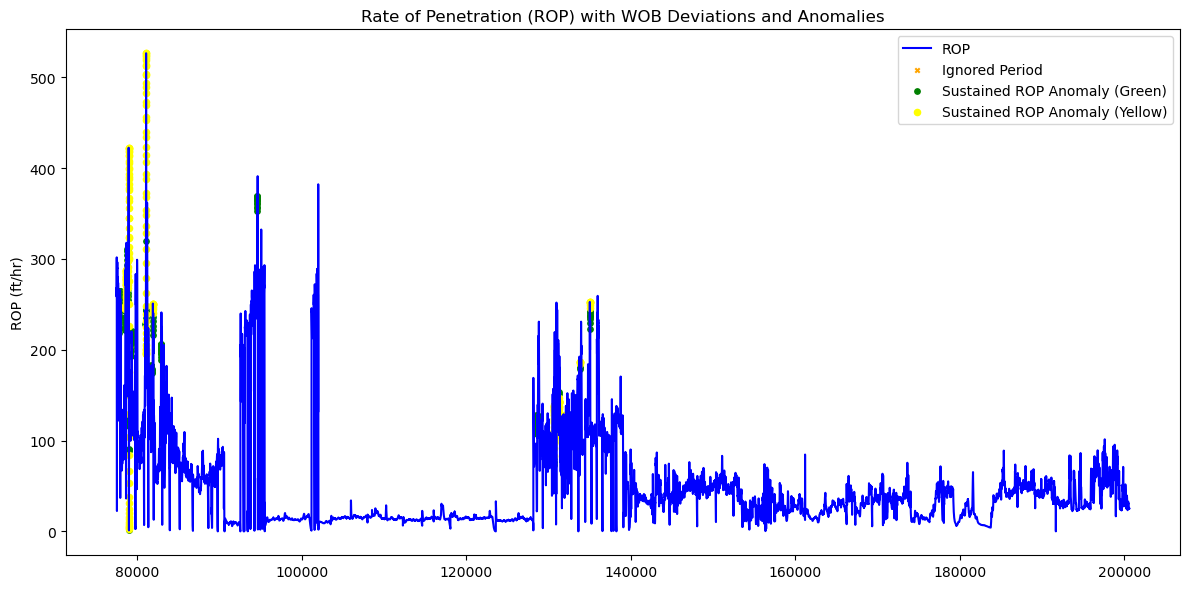

Anomaly Start Points Table (sorted by Hole Depth):


,Rate Of Penetration (ft_per_hr),Hole Depth (feet),Time (sec),Anomaly_Color,YYYY/MM/DD,HH:MM:SS,Weight on Bit (klbs),AutoDriller WOB (klbs)
Time (sec),,,,,,,,
77822,210.30,2026.2,77822,Red,2023/11/11,10:54:05,55.1,55.82
78565,222.22,2059.7,78565,Green,2023/11/11,11:16:45,45.0,45.67
78572,244.98,2060.2,78572,Yellow,2023/11/11,11:16:52,44.0,43.41
78602,272.51,2062.7,78602,Green,2023/11/11,11:17:22,57.7,58.12
78813,293.81,2083.6,78813,Green,2023/11/11,11:35:14,43.7,44.06
78923,255.20,2090.6,78923,Green,2023/11/11,11:37:04,45.7,45.85
78932,267.81,2091.4,78932,Yellow,2023/11/11,11:37:13,37.8,37.69
78992,1.16,2094.2,78992,Green,2023/11/11,11:38:13,11.2,11.15
79017,115.95,2097.3,79017,Green,2023/11/11,11:47:55,59.3,58.27


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def detect_rop_anomalies_with_wob(filtered_data, rop_col="Rate Of Penetration (ft_per_hr)", wob_col="Weight on Bit (klbs)", autodrill_wob_col="AutoDriller WOB (klbs)", wob_threshold=4, rop_threshold=2.5, green_threshold=1.9, window_size=45, ignore_duration=15, proximity_duration=20):
    """
    Detects anomalies by calculating the derivative of ROP and checking if it exceeds a certain threshold.
    Adds color labels based on the severity of the anomaly:
    - Red: Sustained ROP anomaly with significant WOB deviation.
    - Yellow: Sustained ROP anomaly above the yellow threshold.
    - Green: Sustained ROP anomaly between green and yellow thresholds.
    """
    # Calculate the derivative (gradient) of the Rate Of Penetration with respect to the Time (sec) index
    filtered_data['ROP_derivative'] = np.gradient(filtered_data[rop_col], filtered_data.index)
    
    # Create a mask to ignore derivative calculations for 'ignore_duration' seconds after a sudden rise/drop
    ignore_mask = np.zeros(len(filtered_data), dtype=bool)
    for i in range(1, len(filtered_data)):
        if abs(filtered_data['ROP_derivative'].iloc[i] - filtered_data['ROP_derivative'].iloc[i-1]) > rop_threshold:
            ignore_mask[i:i+ignore_duration] = True
    
    # Reset the derivative for the ignore period to avoid false anomaly detection
    filtered_data.loc[ignore_mask, 'ROP_derivative'] = np.nan  # Set derivative as NaN to ignore
    filtered_data['ROP_derivative'] = filtered_data['ROP_derivative'].fillna(method='bfill')  # Optionally fill with next valid value
    
    # Mark anomalies based on the derivative exceeding the threshold
    filtered_data['rop_anomaly'] = filtered_data['ROP_derivative'].apply(lambda x: 1 if x > rop_threshold else 0)
    
    # Check for WOB deviations
    filtered_data['wob_deviation'] = abs(filtered_data[wob_col] - filtered_data[autodrill_wob_col])
    filtered_data['wob_anomaly'] = filtered_data['wob_deviation'].apply(lambda x: 1 if x > wob_threshold else 0)
    
    # Combine conditions: where ROP anomaly and WOB anomaly occur together within a small time window (e.g., 2 seconds)
    time_threshold = 5  # You can adjust this value based on your system's response time tolerance
    combined_anomalies = []
    for i in range(len(filtered_data)):
        if filtered_data['rop_anomaly'].iloc[i] == 1:
            for j in range(i, min(i + time_threshold, len(filtered_data))):
                if filtered_data['wob_anomaly'].iloc[j] == 1:
                    combined_anomalies.append(i)
                    combined_anomalies.append(j)
    
    # Mark combined anomalies (red points)
    filtered_data['combined_anomaly'] = 0
    filtered_data.iloc[combined_anomalies, filtered_data.columns.get_loc('combined_anomaly')] = 1
    
    # Calculate rolling mean of the derivative over the defined window size
    filtered_data['rolling_mean_derivative'] = filtered_data['ROP_derivative'].rolling(window=window_size).mean()
    
    # Mark sustained anomalies based on the rolling mean derivative
    filtered_data['sustained_anomaly_yellow'] = filtered_data['rolling_mean_derivative'].apply(lambda x: 1 if x > rop_threshold else 0)
    filtered_data['sustained_anomaly_green'] = filtered_data['rolling_mean_derivative'].apply(lambda x: 1 if green_threshold < x <= rop_threshold else 0)
    
    # Add a column to label each anomaly as 'Green', 'Yellow', or 'Red', giving priority to 'Red'
    def assign_anomaly_color(row):
        if row['combined_anomaly'] == 1:
            return 'Red'
        elif row['sustained_anomaly_yellow'] == 1:
            return 'Yellow'
        elif row['sustained_anomaly_green'] == 1:
            return 'Green'
        else:
            return 'None'

    filtered_data['Anomaly_Color'] = filtered_data.apply(assign_anomaly_color, axis=1)

    # Check if yellow anomalies are close to red anomalies (within proximity_duration)
    red_anomalies = filtered_data[filtered_data['Anomaly_Color'] == 'Red'].index
    yellow_anomalies = filtered_data[filtered_data['Anomaly_Color'] == 'Yellow'].index
    
    for red_index in red_anomalies:
        # Find yellow anomalies that are within proximity_duration seconds of red anomaly
        proximity_mask = (yellow_anomalies >= red_index - proximity_duration) & (yellow_anomalies <= red_index + proximity_duration)
        close_yellows = yellow_anomalies[proximity_mask]
        
        # Convert those yellow anomalies to red
        filtered_data.loc[close_yellows, 'Anomaly_Color'] = 'Red'

    return filtered_data


def plot_rop_wob_anomalies_with_sustained(result_df, rop_col="Rate Of Penetration (ft_per_hr)", depth_col="Hole Depth (feet)", wob_col="Weight on Bit (klbs)"):
    """
    Plots the Rate Of Penetration (ROP), WOB deviations, sustained anomalies, and anomaly points.
    Green for lower sustained ROP anomalies, Yellow for sustained ROP anomalies, Red for both ROP derivative and WOB anomalies in close proximity.
    """
    # Detect anomaly points for both ROP derivative and WOB deviation
    anomaly_start_points = detect_anomaly_start_points(result_df)

    # Create the plot for ROP and anomalies (remove the second subplot)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))  # Changed from 2, 1 to 1, 1

    # Plot ROP with anomalies
    ax.plot(result_df.index, result_df[rop_col], label='ROP', color='blue')
    ax.set_ylabel('ROP (ft/hr)')
    ax.set_title('Rate of Penetration (ROP) with WOB Deviations and Anomalies')

    # Mark periods where derivative calculations were ignored (NaN in 'ROP_derivative')
    ignored_periods = result_df[result_df['ROP_derivative'].isna()]
    ax.scatter(ignored_periods.index, ignored_periods[rop_col], label='Ignored Period', color='orange', s=10, marker='x')

    # Mark sustained ROP anomaly points in green
    green_anomalies = result_df[result_df['Anomaly_Color'] == 'Green']
    ax.scatter(green_anomalies.index, green_anomalies[rop_col], label='Sustained ROP Anomaly (Green)', color='green', s=15)

    # Mark sustained ROP anomaly points in yellow
    yellow_anomalies = result_df[result_df['Anomaly_Color'] == 'Yellow']
    ax.scatter(yellow_anomalies.index, yellow_anomalies[rop_col], label='Sustained ROP Anomaly (Yellow)', color='yellow', s=20)

    plt.tight_layout()
    plt.legend()
    plt.show()

    # Print the table of anomaly start points with the anomaly color
    print("Anomaly Start Points Table (sorted by Hole Depth):")
    display(anomaly_start_points[['Rate Of Penetration (ft_per_hr)', 'Hole Depth (feet)', 'Time (sec)', 'Anomaly_Color', 'YYYY/MM/DD', 'HH:MM:SS', 'Weight on Bit (klbs)', 'AutoDriller WOB (klbs)']])

# Example usage
result_df = detect_rop_anomalies_with_wob(filtered_data, rop_col='Rate Of Penetration (ft_per_hr)', wob_col='Weight on Bit (klbs)', autodrill_wob_col='AutoDriller WOB (klbs)')
plot_rop_wob_anomalies_with_sustained(result_df, rop_col='Rate Of Penetration (ft_per_hr)', depth_col='Hole Depth (feet)', wob_col='Weight on Bit (klbs)')
